# Effects of changes at surface

This notebook is to investigate the odd structure of vertical velocities observed throughout season, with a particularly notable example with our A11 winter data. Seen here in the vertical veolcities plot: 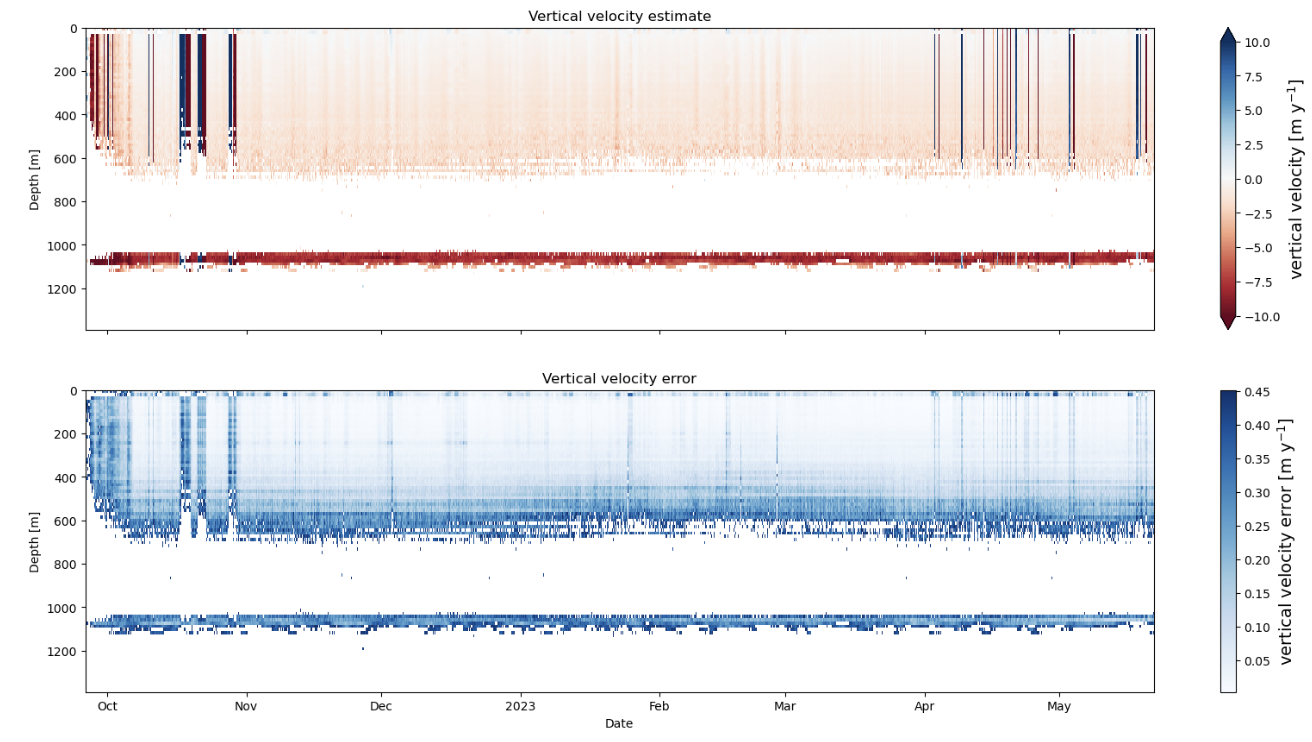

I will select the period in between octover and November where there are obvious changes in vertical velocity. 

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import pickle

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress
from helpers import *

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    15:33:29 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    15:33:29 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    15:33:29 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34715")
client

<Client: 'tcp://127.0.0.1:34715' processes=4 threads=16, memory=125.80 GiB>

In [3]:
def strain_metrics(ds, win_cor, step, lag, noise_floor):
    # This function, given a window, and step, gives a total percentage of data that has high coherence
    b1 = ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    dz, co, phi = xa.generate_range_diff(b1,b2,win_cor,step,None,0,0.95)
    dz=dz.assign(coherence=(['time','profile_range'],co))
    dz_new = dz.where(abs(dz.coherence) > 0.95).drop_duplicates('time')

    vv = dz_new.range_diff / dz_new.time_diff * 31536000
    vv_err = dz_new.err / dz_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=noise_floor).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv.where(vv.profile_range <=noise_floor)-vv.where(vv.profile_range <=noise_floor).mean())**2).sum(dim='profile_range')
    
    slope = fit.polyfit_coefficients.sel(degree=1)*vv.profile_range+fit.polyfit_coefficients.sel(degree=0)
    residual = vv-slope
    residual = residual.where(residual.profile_range <=noise_floor,drop=True)
    slope_errs = np.sqrt((1/(len(residual.profile_range)-2))*(((residual**2).sum(dim='profile_range'))/((residual.profile_range - residual.profile_range.mean())**2).sum()))

    return np.count_nonzero(abs(co)>0.95)/np.count_nonzero(co),np.mean(r2).values,[vv,vv_err,fit,r2,slope_errs]

def optimal_window_and_leapfrog(ds,noise_floor):
    max_score = 0
    windows = np.arange(20,90,20)
    lags = np.round(np.logspace(0,3,4)).astype('int')
    co_mat = np.zeros((len(windows),len(lags)))
    r2_mat = np.zeros((len(windows),len(lags)))
    for i in range(len(windows)):
        step = windows[i] # earlier experiments show step doesn't change results by much
        #for step in [10,20,40,80]:
        #    if step <= window:
        for j in range(len(lags)):
            count,r2,res = strain_metrics(ds, windows[i], step,lags[j],noise_floor)
            print(f"Window {windows[i]}, lag {lags[j]} -> frac high co {count:.2}, r2 {r2:.2}")
            co_mat[i,j] = count
            r2_mat[i,j]=r2
            # mean coherence not relevant I think
            temp_score = count+r2
            if temp_score > max_score:
                max_score = temp_score
                to_return = windows[i],lags[j],res
            
    fig, axs = plt.subplots(ncols=2,figsize=(15,5))
    plt0 = axs[0].pcolormesh(100*co_mat)
    plt.colorbar(plt0,ax=axs[0],label='fraction of data with |coherence|>0.95')
    axs[0].set_xticks(np.arange(co_mat.shape[1]) + 0.5, minor=False)
    axs[0].set_yticks(np.arange(co_mat.shape[0]) + 0.5, minor=False)
    axs[0].set_xticklabels(lags)
    axs[0].set_yticklabels(windows)
    axs[0].set_ylabel('Correlation window size [points included]')
    axs[0].set_xlabel('Lag between bursts [num. bursts seperated]')
    axs[0].set_title('fraction of data with high coherence')

    plt1 = axs[1].pcolormesh(r2_mat)
    plt.colorbar(plt1,ax=axs[1],label='Average r^2 of linear strain fits')
    axs[1].set_xticks(np.arange(r2_mat.shape[1]) + 0.5, minor=False)
    axs[1].set_yticks(np.arange(r2_mat.shape[0]) + 0.5, minor=False)
    axs[1].set_xticklabels(lags)
    axs[1].set_yticklabels(windows)
    axs[1].set_ylabel('Correlation window size [points included]')
    axs[1].set_xlabel('Lag between bursts [num. bursts seperated]')
    axs[1].set_title('Mean strain rate fit r-squared')

    return to_return
    
def plot_strain_fit(res,xlims=None,ylims=None):
    vv = res[0]
    vv_err = res[1]
    fit=res[2]
    r2 = res[3]
    slope_err = res[4]
    fig, ax = plt.subplots(figsize=(10,5))
    ax.errorbar(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values,yerr=slope_err.values,linestyle='None',marker='.',ecolor='k')
    if ylims:
        ax.set_ylim(ylims)
    ax.set_ylabel('Strain rate [y$^{-1}$]')
    ax.set_title('Strain fitting results')
    ax.set_xlabel('Date')
    plt.yscale('symlog',linthresh=1e-2)

    fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
    #fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
    vv_times = np.arange(math.ceil(0.05*len(vv.time)),len(vv.time),len(vv.time)//10)
    for i in range(10):
        time = vv.time.isel(time = vv_times[i]).values
        axs_1[i].errorbar(vv.sel(time = time,method="nearest") ,vv.profile_range,yerr=None,xerr=vv_err.sel(time = time,method="nearest"),marker='.',linestyle='None',zorder=1)
        slope = fit.polyfit_coefficients.sel(degree=1).isel(time=vv_times[i]).values*np.linspace(20,600)+fit.polyfit_coefficients.sel(degree=0).isel(time=vv_times[i]).values

        axs_1[i].plot(slope,np.linspace(20,600),color='r',zorder=2)
        unit = ''#'x10$^{-3}$ yr$^{-1}$'
        #axs_1[plt_count].text(-10,300, f"\u03B5\u0307= {fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
        axs_1[i].set_title(f'{time.astype(str)[:10]}')
        if xlims:
            axs_1[i].set_xlim(xlims)
        axs_1[i].set_ylim([20,1400])
        axs_1[i].tick_params(axis='both', which='major', labelsize=14)


    axs_1[0].invert_yaxis()

    axs_1[0].set_ylabel('depth [m]',fontsize=18)
    fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)

def plot_vv_2d(res,xlims=None):
    vv = res[0]
    vv_err = res[1]
    fit=res[2]
    r2 = res[3]
    fig, axs = plt.subplots(figsize=(20,10),nrows=2,sharex=True)
    plt1 = vv.plot(ax=axs[0],x='time',cmap='RdBu',vmin=-10,vmax=10)
    axs[0].invert_yaxis()
    axs[0].set_title('Vertical velocity estimate')
    axs[0].set_xlabel('')
    plt1.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)

    plt2 = vv_err.plot(ax=axs[1],x='time',cmap='Blues')
    axs[1].invert_yaxis()
    axs[1].set_xlabel('Date')
    axs[1].set_title('Vertical velocity error')
    if xlims:
        plt.xlim(xlims)
    plt2.colorbar.set_label(label='vertical velocity error [m y$^{-1}$]', size=14)





In [4]:
with open('../chirp_processing/A11_22W.pickle', 'rb') as handle:
    winter = pickle.load(handle)

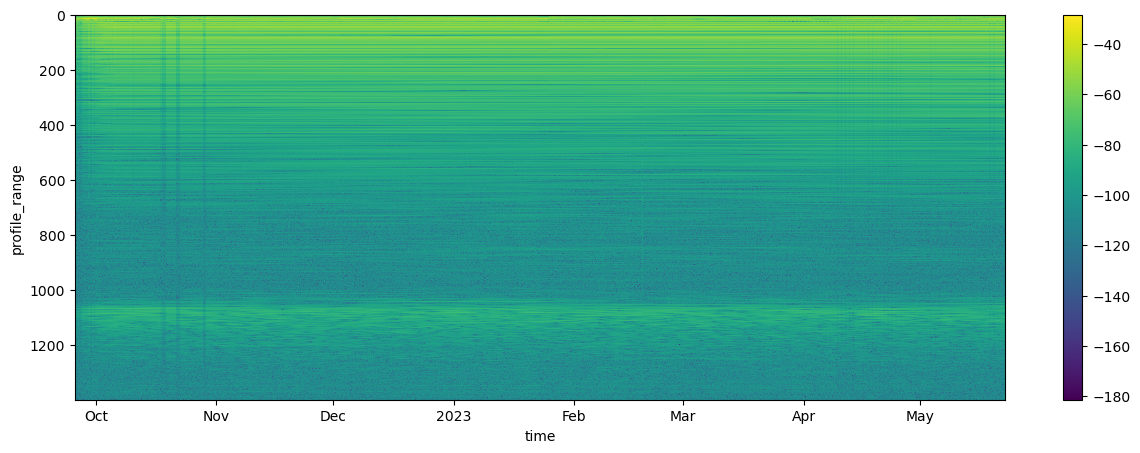

In [5]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(winter).plot(x='time')
ax.invert_yaxis()
#import datetime
#xlim=[datetime.date(2022, 12, 1), datetime.date(2023, 4, 1)]
#plt.xlim(xlim)

In [6]:
time_to_interp = pd.date_range("2022-10-20 12:00", "2022-11-01 12:00", freq="15min")
interp_profiles = winter.interp(time=time_to_interp,method='linear')


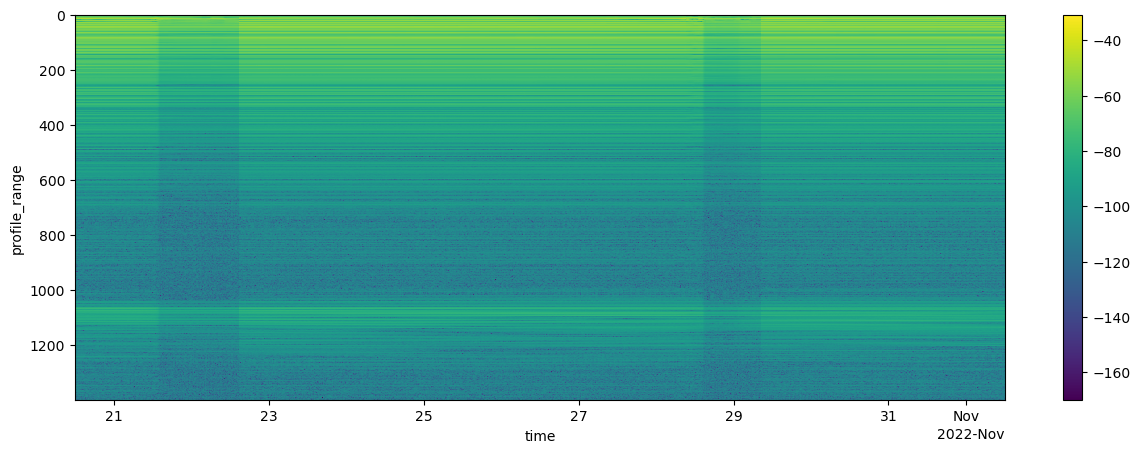

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(interp_profiles).plot(x='time')
ax.invert_yaxis()
#import datetime
#xlim=[datetime.date(2022, 12, 1), datetime.date(2023, 4, 1)]
#plt.xlim(xlim)

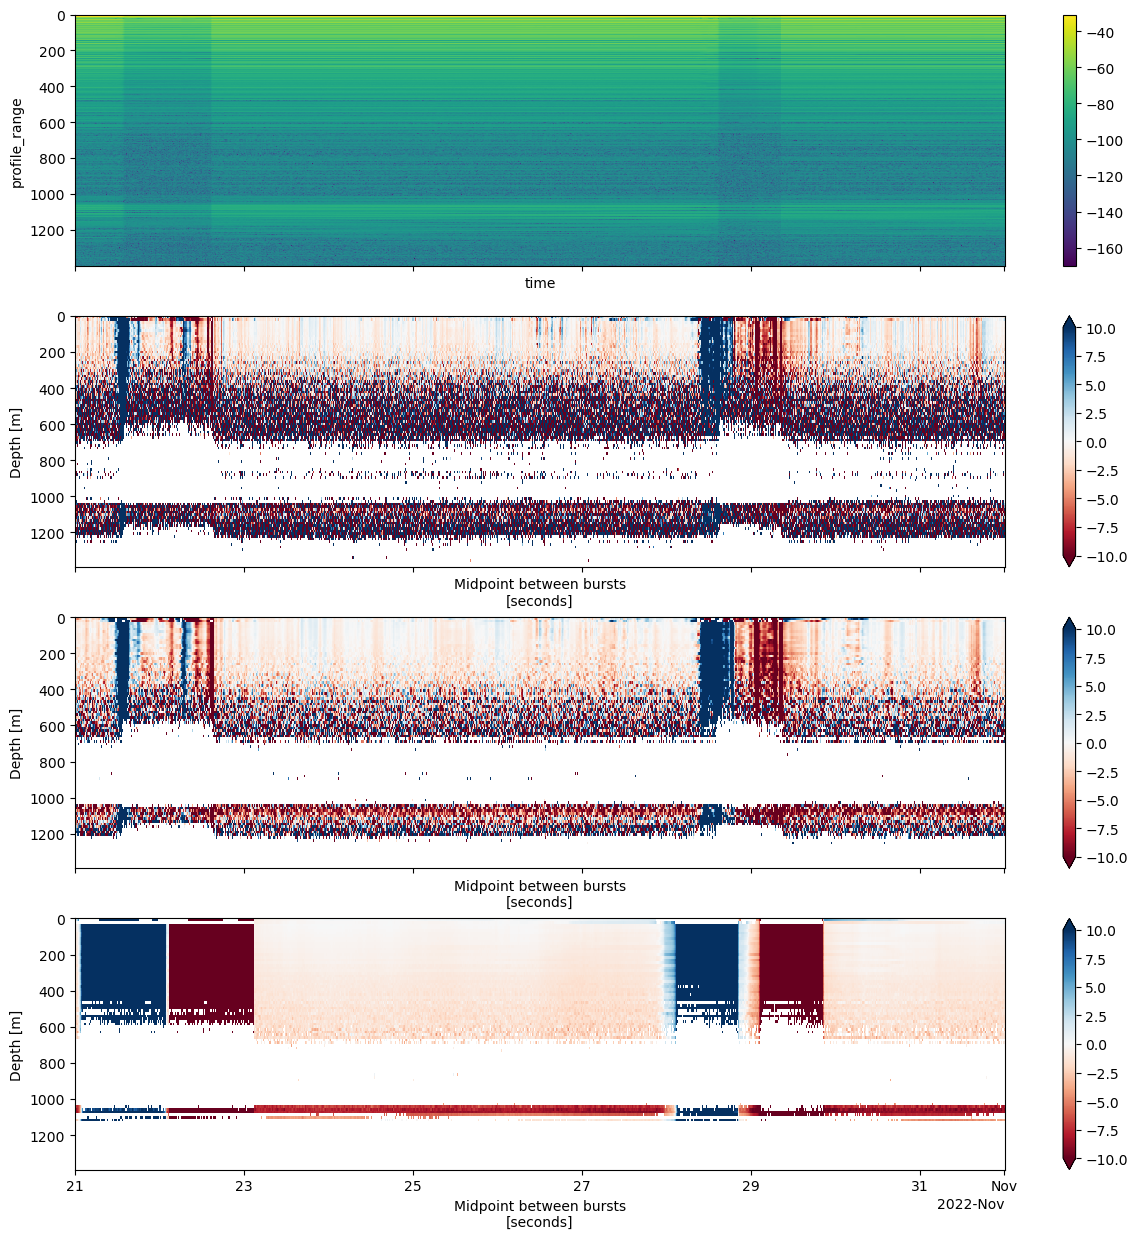

In [8]:
# Look at how this affects displacement estimates
fig, axs = plt.subplots(nrows=4,figsize=(15,15),sharex=True)
xa.dB(interp_profiles).plot(ax=axs[0],x='time')
axs[0].invert_yaxis()
windows = [1,4,96]
labels = ['15 minutes','1 hour','1 day']

for i in range(3):
    count,r2,res = strain_metrics(interp_profiles, 70, 70,windows[i],700)
    vv = res[0]
    vv.plot(ax=axs[1+i],x='time',cmap='RdBu',vmin=-10,vmax=10)
    axs[i+1].invert_yaxis()

Also a sanity check on our vertical velocity calculations. We expect water at the surface to make the englacial reflectors further away? Light travels slower through water than ice. This makes the travel time longer and the apparent reflectors further. 

It's clear that the change in amplitude results in artiacts appearing in resulting velocity estimates. Let's try to understand the changes.

Text(0.5, 1.0, 'Phase')

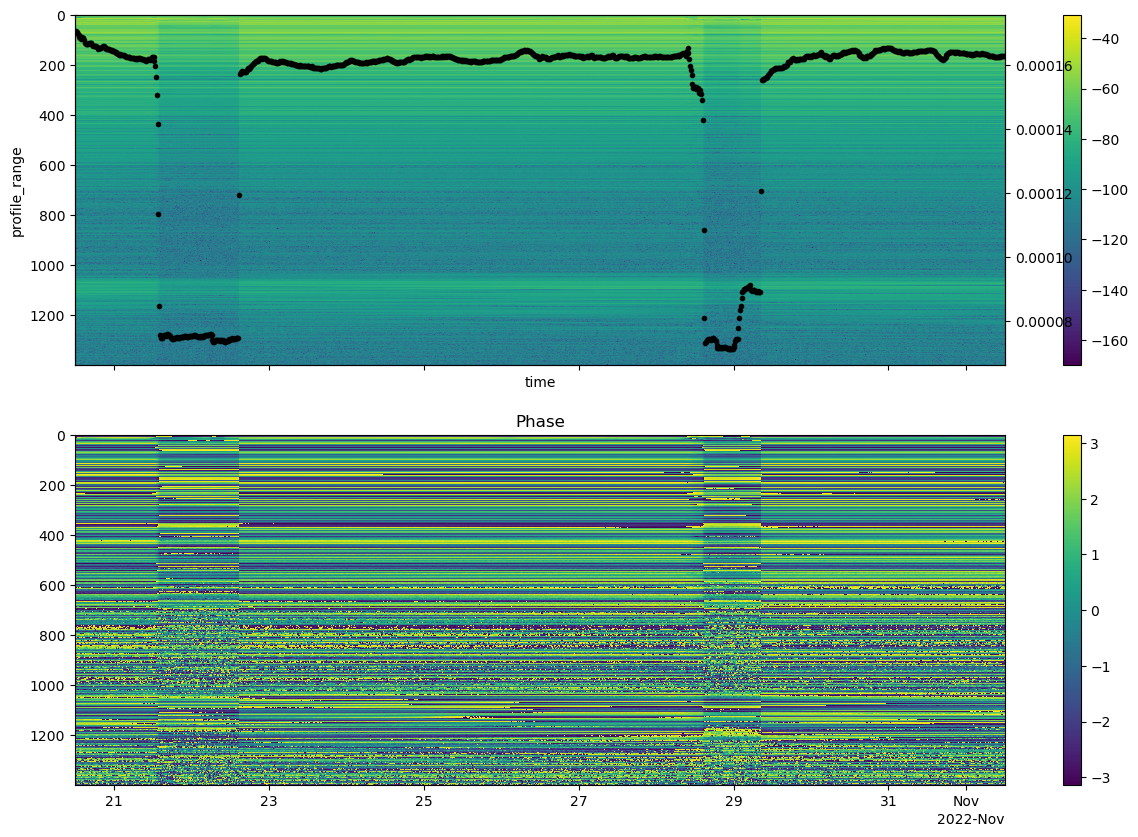

In [9]:
fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)
fg=xa.dB(interp_profiles).plot(ax=axs[0],x='time')
axs[0].invert_yaxis()
ax1 = axs[0].twinx()
abs(interp_profiles).mean(dim='profile_range').plot(ax=ax1,color='k',linestyle='None',marker='.')

phi = -np.angle(interp_profiles).astype(float)
im = axs[1].pcolormesh(interp_profiles.time.values,interp_profiles.profile_range.values,phi.T)
axs[1].invert_yaxis()
fig.colorbar(im)
axs[1].set_title('Phase')

There are clear shifts in phase that arise from the changes in amplitude

In [10]:
ds_11_w = reload_winter("A101")
voltage = ds_11_w.battery_voltage.interp(time=time_to_interp,method='linear').compute()
temp1 = ds_11_w.temperature_1
true_temp1 = temp1.where(lambda x: x<300, temp1-512).interp(time=time_to_interp,method='linear').compute()

temp2 = ds_11_w.temperature_2
true_temp2 = temp2.where(lambda x: x<300, temp2-512).interp(time=time_to_interp,method='linear').compute()


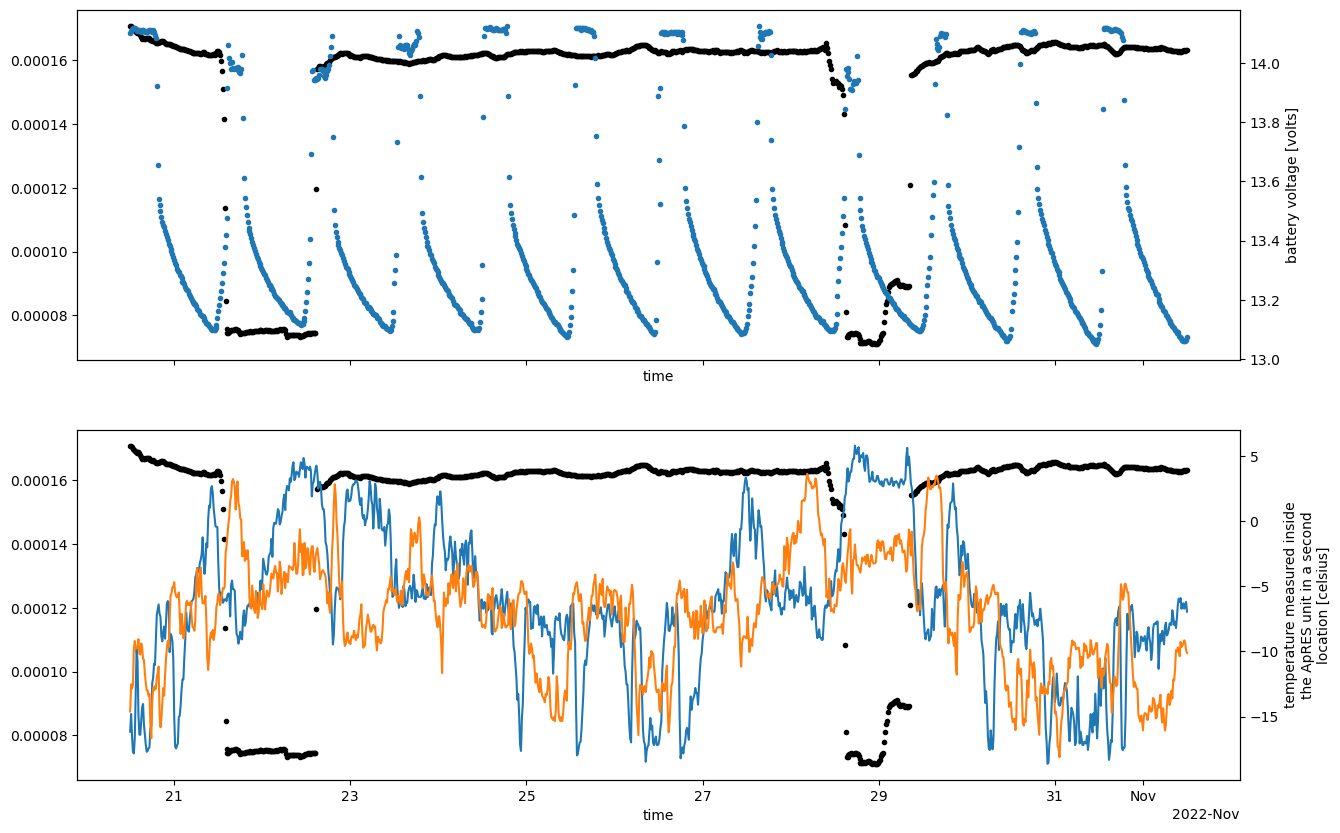

In [11]:
fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)
abs(interp_profiles).mean(dim='profile_range').plot(ax=axs[0],color='k',linestyle='None',marker='.')
ax1 = axs[0].twinx()
voltage.plot(ax=ax1,linestyle='None',marker='.')

abs(interp_profiles).mean(dim='profile_range').plot(ax=axs[1],color='k',linestyle='None',marker='.')
ax2 = axs[1].twinx()
true_temp1.plot(ax=ax2)
true_temp2.plot(ax=ax2)


I suspect melt at the surface is what causes the changes. 

## Examining mean profile amplitudes

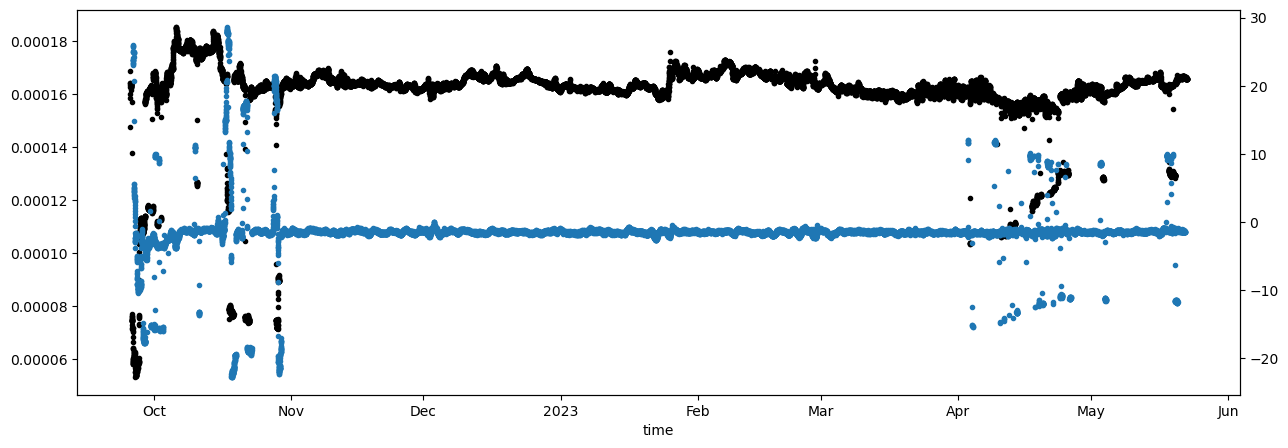

In [12]:
fig, ax = plt.subplots(figsize=(15,5))

abs(winter).mean(dim='profile_range').plot(ax=ax,color='k',linestyle='None',marker='.')
ax1= ax.twinx()
count,r2,res = strain_metrics(winter, 70, 70,96,700)
vv = res[0]
vv.mean(dim='profile_range').plot(ax=ax1,x='time',linestyle='None',marker='.')

## Closer look at transition

In [13]:
time_to_interp_short = pd.date_range("2022-10-21 08:00", "2022-10-21 20:00", freq="15min")
interp_profiles_short = winter.interp(time=time_to_interp_short,method='linear')


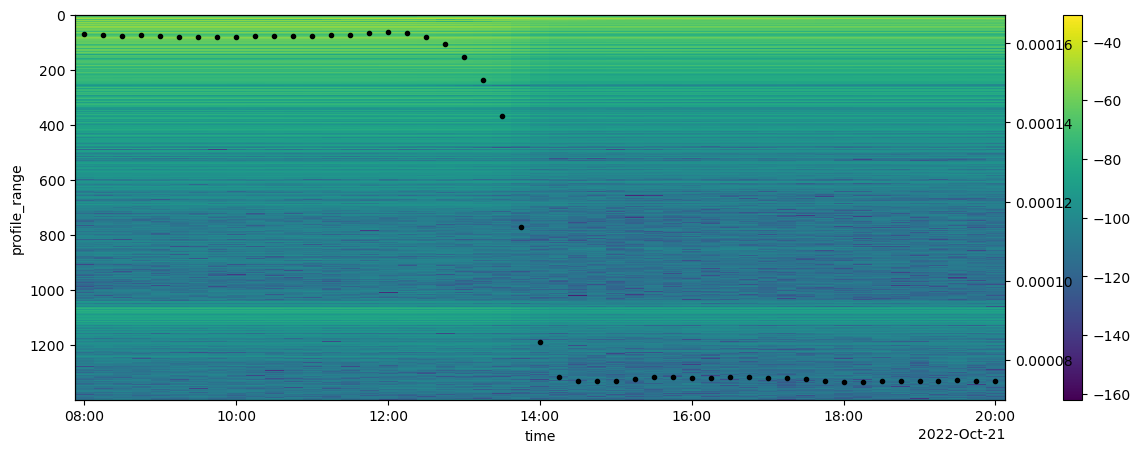

In [15]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(interp_profiles_short).plot(x='time')
ax.invert_yaxis()
ax1 = ax.twinx()
abs(interp_profiles_short).mean(dim='profile_range').plot(ax=ax1,color='k',linestyle='None',marker='.')

#import datetime
#xlim=[datetime.date(2022, 12, 1), datetime.date(2023, 4, 1)]
#plt.xlim(xlim)

Text(0.5, 1.0, 'Phase')

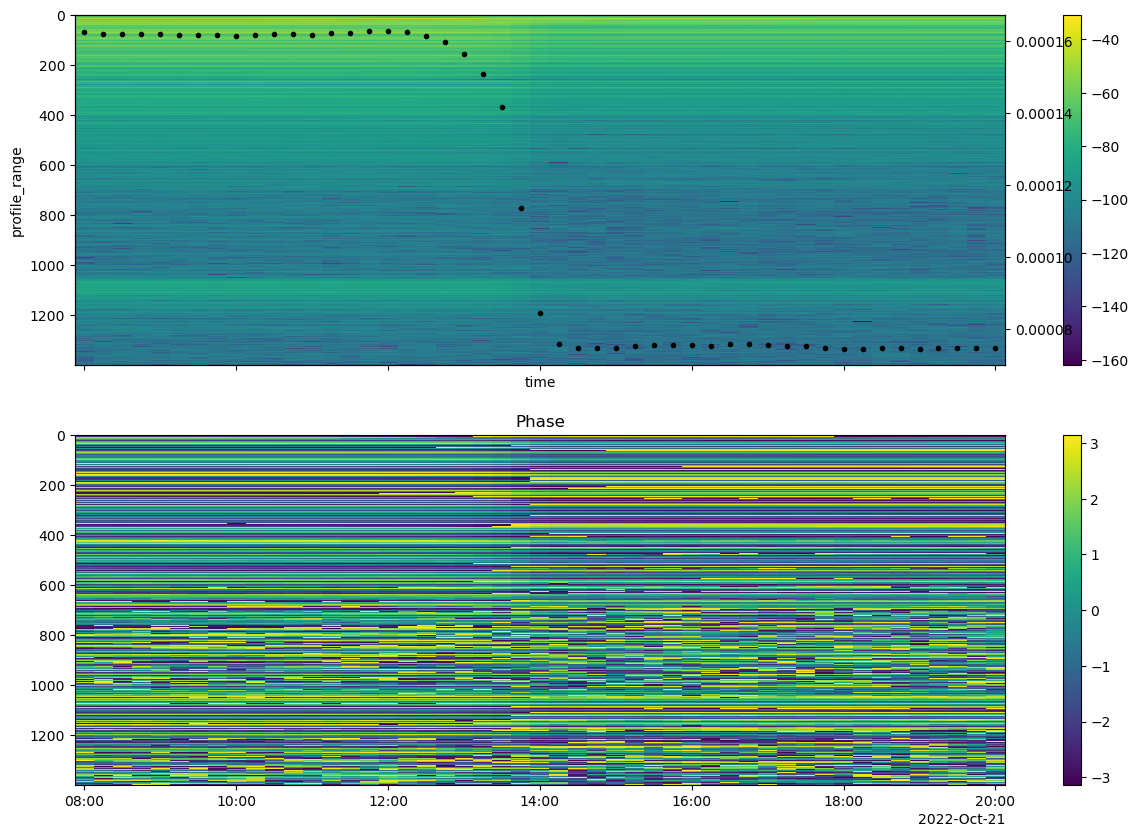

In [88]:
fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)
fg=xa.dB(interp_profiles_short).plot(ax=axs[0],x='time')
axs[0].invert_yaxis()
ax1 = axs[0].twinx()
abs(interp_profiles_short).mean(dim='profile_range').plot(ax=ax1,color='k',linestyle='None',marker='.')

phi = -np.angle(interp_profiles_short).astype(float)
im = axs[1].pcolormesh(interp_profiles_short.time.values,interp_profiles_short.profile_range.values,phi.T)
axs[1].invert_yaxis()
fig.colorbar(im)
axs[1].set_title('Phase')

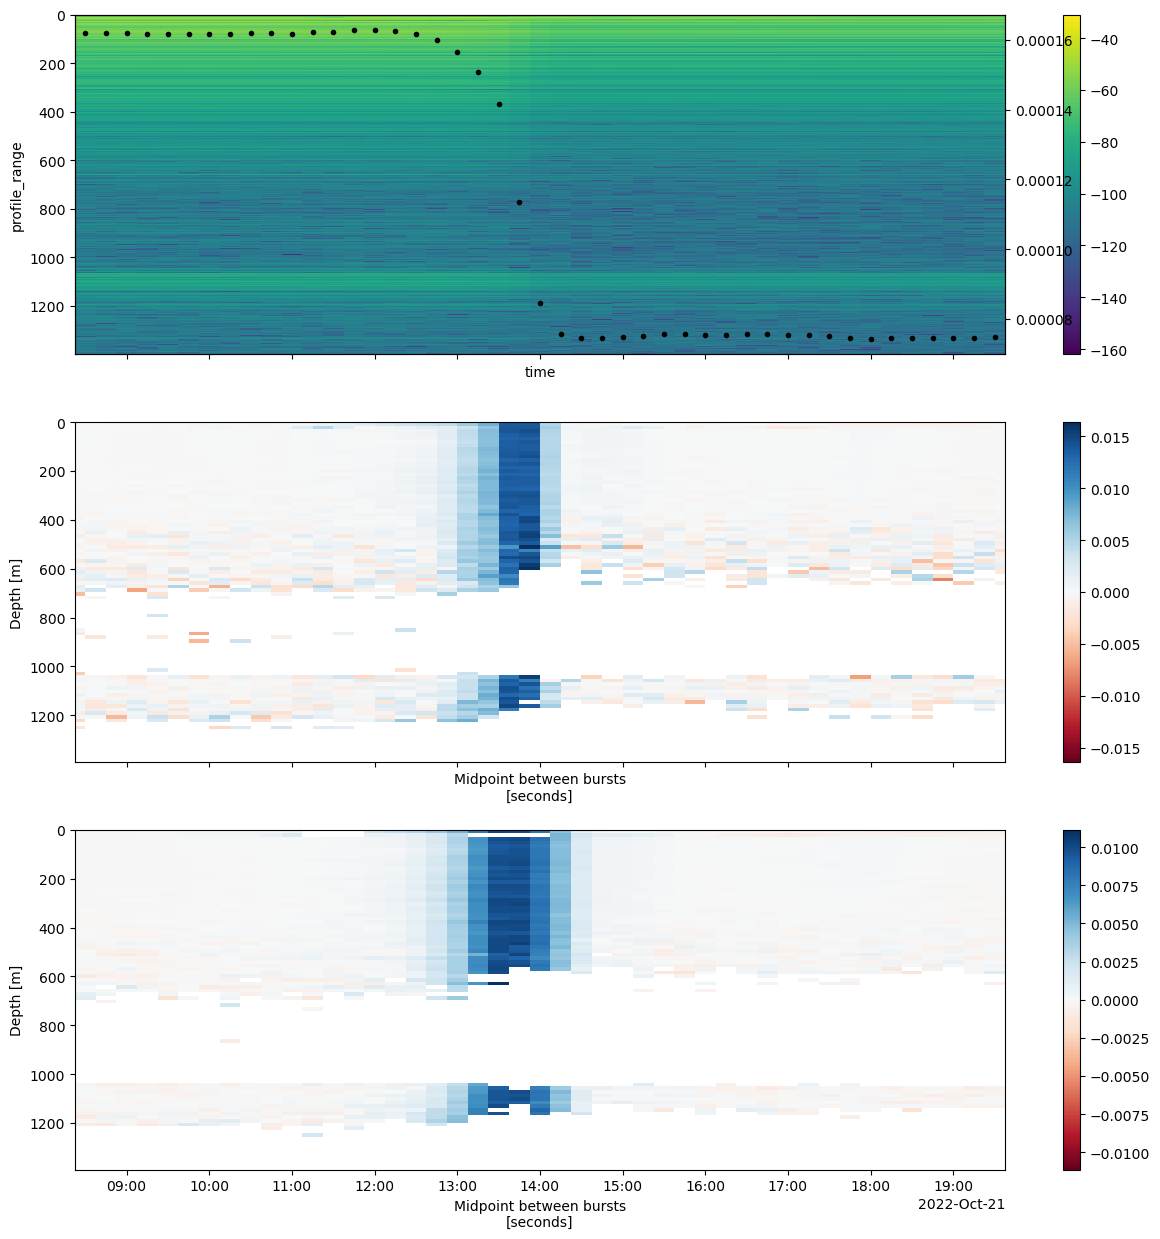

In [31]:
# Look at how this affects displacement estimates
fig, axs = plt.subplots(nrows=3,figsize=(15,15),sharex=True)
xa.dB(interp_profiles_short).plot(ax=axs[0],x='time')
axs[0].invert_yaxis()
ax1 = axs[0].twinx()
abs(interp_profiles_short).mean(dim='profile_range').plot(ax=ax1,color='k',linestyle='None',marker='.')

windows = [1,4,96]
labels = ['15 minutes','1 hour','1 day']


for i in range(2):
    count,r2,res = strain_metrics(interp_profiles_short, 70, 70,windows[i],700)
    vv = res[0]*900/31536000
    vv.plot(ax=axs[1+i],x='time',cmap='RdBu')#,vmin=-100,vmax=100)
    axs[i+1].invert_yaxis()

In [32]:
ds_11_w = reload_winter("A101")
voltage = ds_11_w.battery_voltage.interp(time=time_to_interp_short,method='linear').compute()
temp1 = ds_11_w.temperature_1
true_temp1 = temp1.where(lambda x: x<300, temp1-512).interp(time=time_to_interp_short,method='linear').compute()

temp2 = ds_11_w.temperature_2
true_temp2 = temp2.where(lambda x: x<300, temp2-512).interp(time=time_to_interp_short,method='linear').compute()


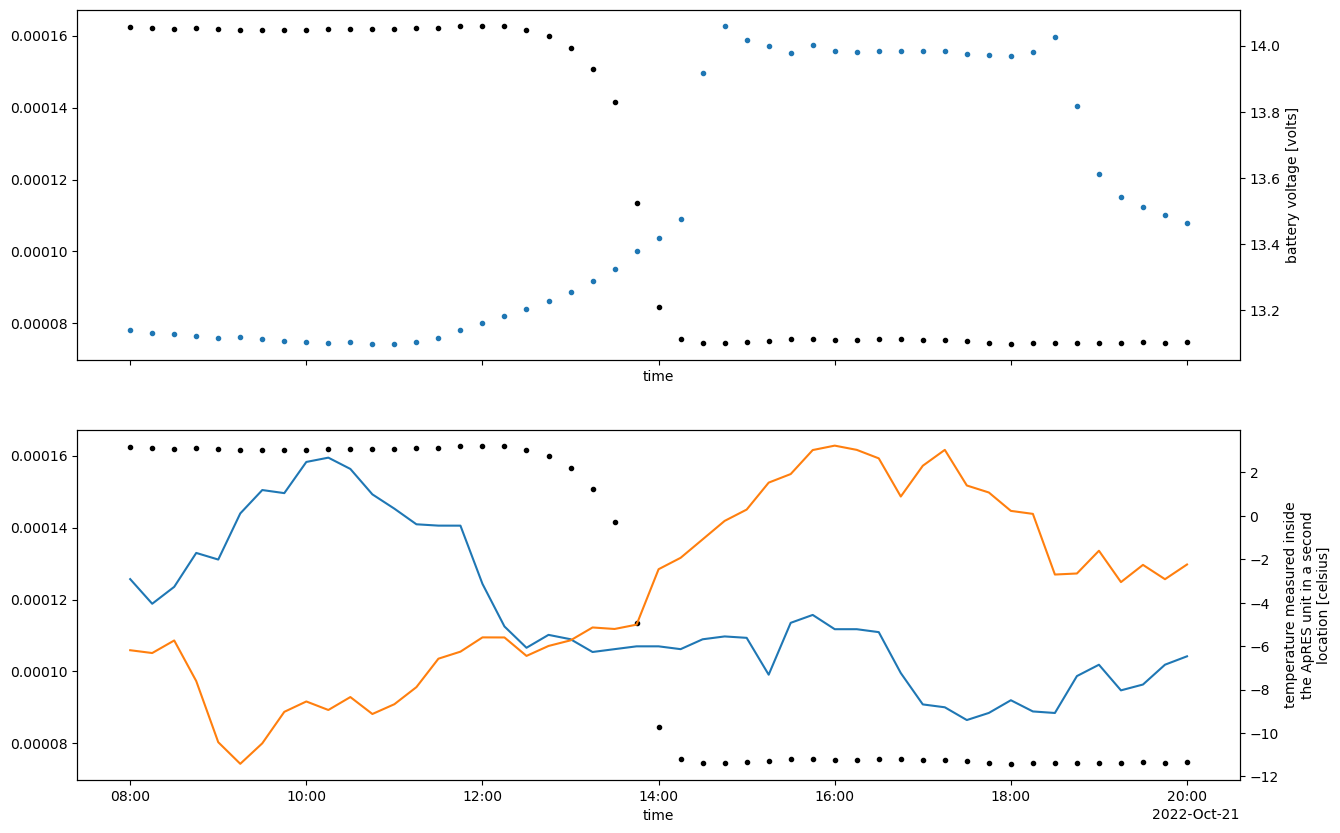

In [33]:
fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)
abs(interp_profiles_short).mean(dim='profile_range').plot(ax=axs[0],color='k',linestyle='None',marker='.')
ax1 = axs[0].twinx()
voltage.plot(ax=ax1,linestyle='None',marker='.')

abs(interp_profiles_short).mean(dim='profile_range').plot(ax=axs[1],color='k',linestyle='None',marker='.')
ax2 = axs[1].twinx()
true_temp1.plot(ax=ax2)
true_temp2.plot(ax=ax2)


In [19]:
res[0]

<xarray.DataArray (time: 45, profile_range: 94)> Size: 34kB
array([[  3.16999668,   2.20436736,  -1.0462624 , ...,          nan,
                 nan,          nan],
       [  3.35061502,   1.81815624,  -0.79390946, ...,          nan,
                 nan,          nan],
       [  3.94626552,   3.22525579,  -1.09432419, ...,          nan,
                 nan,          nan],
       ...,
       [-24.04791039, -12.93426514,  -1.1331685 , ...,          nan,
                 nan,          nan],
       [-19.50443045, -12.51077252,  -1.75182975, ...,          nan,
                 nan,          nan],
       [-15.60939192, -12.60356423,  -1.65947535, ...,          nan,
                 nan,          nan]])
Coordinates:
  * time           (time) datetime64[ns] 360B 2022-10-21T08:30:00 ... 2022-10...
  * profile_range  (profile_range) float64 752B 7.397 22.19 ... 1.383e+03

In [21]:
ds_11_w = reload_winter("A101")
chirps = ds_11_w.chirp.isel(attenuator_setting_pair=0).interp(time=time_to_interp_short,method='linear').compute()

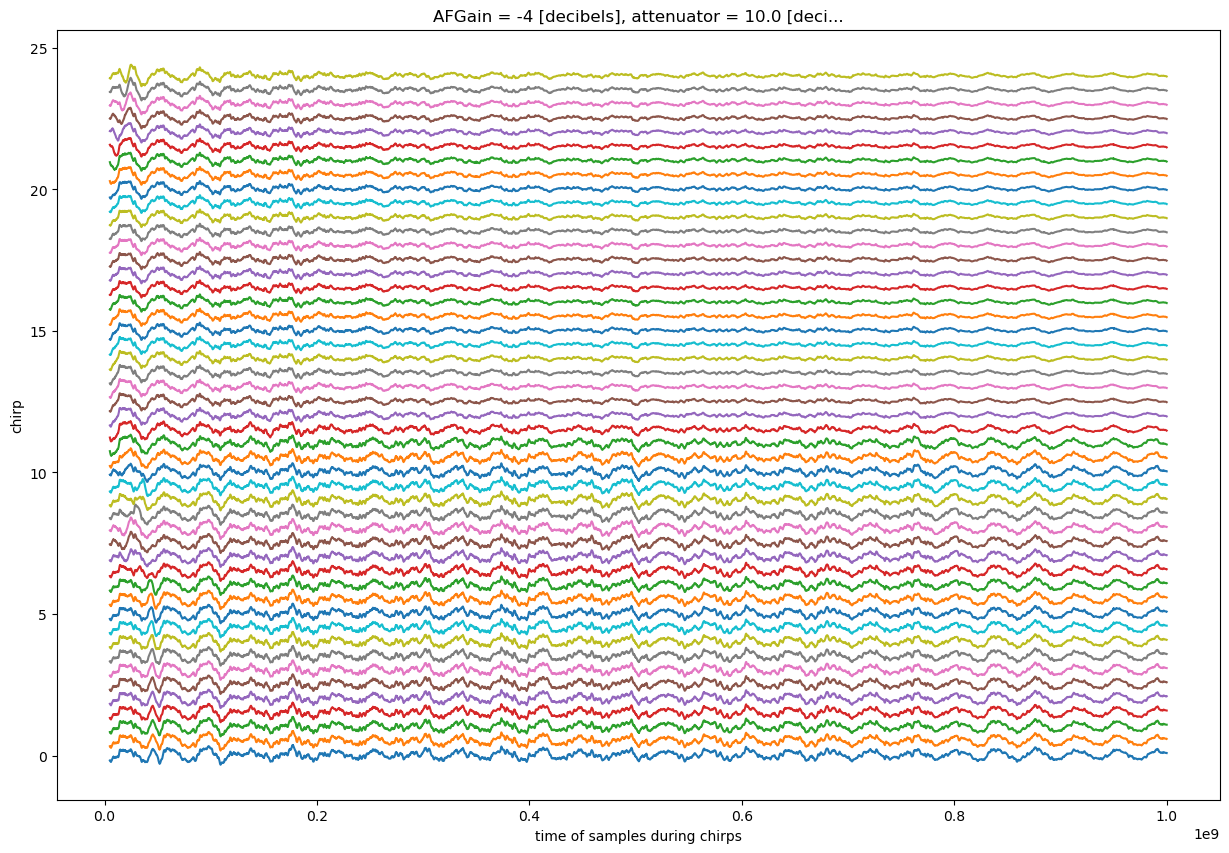

In [24]:
fig, ax = plt.subplots(figsize=(15,10))
for i in range(len(chirps.time)):
    chirp = chirps.isel(time= [i],chirp_time=range(200,39998)).mean(dim='chirp_num')
    (chirp+i/2).plot()
    #axs[i].set_title(f'Time: {str(chirp.time.values[0])[:16]}')
    #axs[i].set_xlabel('')
    #axs[i].set_ylim([-1,1])
#axs[-1].set_xlabel('chirp time [ns]')


Text(0.5, 0, 'chirp time [ns]')

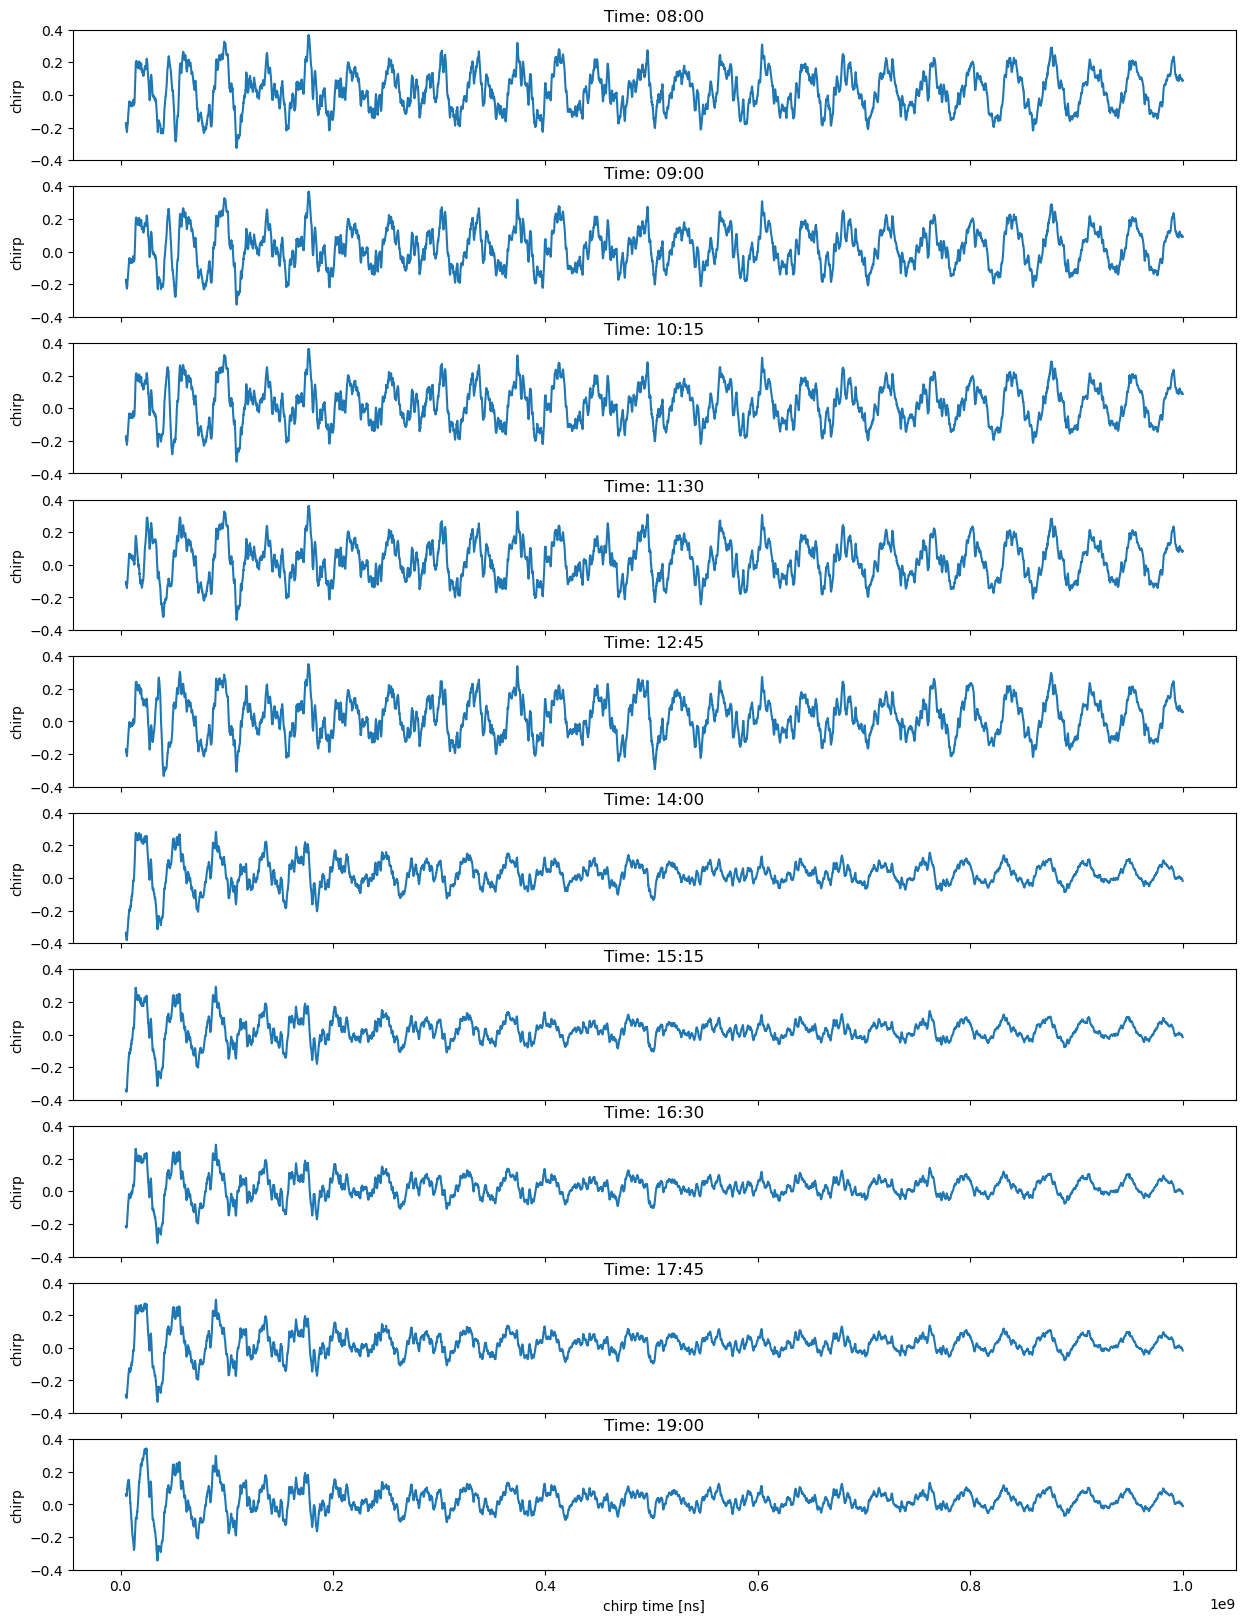

In [22]:
fig, axs = plt.subplots(nrows=10,figsize=(15,20),sharex=True)
for i in range(10):
    chirp = chirps.isel(time= [i*49//10],chirp_time=range(200,39998)).mean(dim='chirp_num')
    chirp.plot(ax=axs[i])
    axs[i].set_title(f'Time: {str(chirp.time.values[0])[11:16]}')
    axs[i].set_xlabel('')
    axs[i].set_ylim([-0.4,0.4])
axs[-1].set_xlabel('chirp time [ns]')


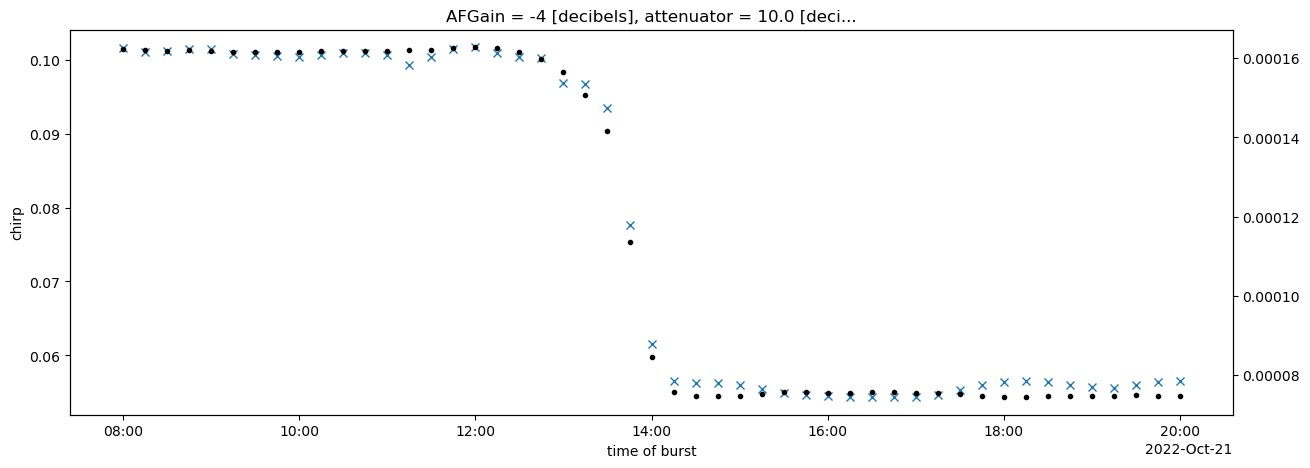

In [28]:
fig, axs = plt.subplots(nrows=1,figsize=(15,5),sharex=True)

abs(chirps.isel(chirp_time=range(200,39998))).mean(dim=['chirp_time','chirp_num']).plot(ax=axs,linestyle='None',marker='x',label='mean chirp amplitude')
ax1=axs.twinx()
abs(interp_profiles_short).mean(dim='profile_range').plot(ax=ax1,color='k',linestyle='None',marker='.',label='mean profile amplitude')